### Important Imports

In [32]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold , learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)



### reading data

In [33]:
#read the Excel file
df_raw = pd.read_excel(r"D:\Downloads\Social_Network_Ads(1).xls", header=None)

#split the first column by commas
df = df_raw[0].str.split(',', expand=True)

df.columns = df.iloc[0]      # use first row as header
df = df[1:]                  # drop the header row from data

#reset index if needed
df.reset_index(drop=True, inplace=True)

#Preview the cleaned dataframe
print(df.head())

0   User ID  Gender Age EstimatedSalary Purchased
0  15624510    Male  19           19000         0
1  15810944    Male  35           20000         0
2  15668575  Female  26           43000         0
3  15603246  Female  27           57000         0
4  15804002    Male  19           76000         0


## explore and clean

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    object
 1   Gender           400 non-null    object
 2   Age              400 non-null    object
 3   EstimatedSalary  400 non-null    object
 4   Purchased        400 non-null    object
dtypes: object(5)
memory usage: 15.8+ KB


In [35]:
df.isnull().sum()

0
User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [36]:
df.duplicated().sum()

np.int64(0)

In [37]:
cols = ['Age', 'EstimatedSalary', 'Purchased' ,'User ID' ]
df[cols] = df[cols].apply(pd.to_numeric)


In [38]:
df.dtypes

0
User ID             int64
Gender             object
Age                 int64
EstimatedSalary     int64
Purchased           int64
dtype: object

In [39]:
df.isnull().sum()

0
User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [40]:
df.duplicated().sum()

np.int64(0)

In [41]:
df.describe(percentiles=[.1,.25,.5,.75,.9,.99])

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
10%,1.559187e+07,24.000000,26000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
90%,1.579119e+07,52.100000,122000.000000,1.000000
99%,1.581312e+07,60.000000,148010.000000,1.000000


## label encodeing

In [42]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#alphipatically
df['Gender'] = le.fit_transform(df['Gender'])
df.head()


,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,1,19,19000,0
1,15810944,1,35,20000,0
2,15668575,0,26,43000,0
3,15603246,0,27,57000,0
4,15804002,1,19,76000,0


## correlation matrix to get important features

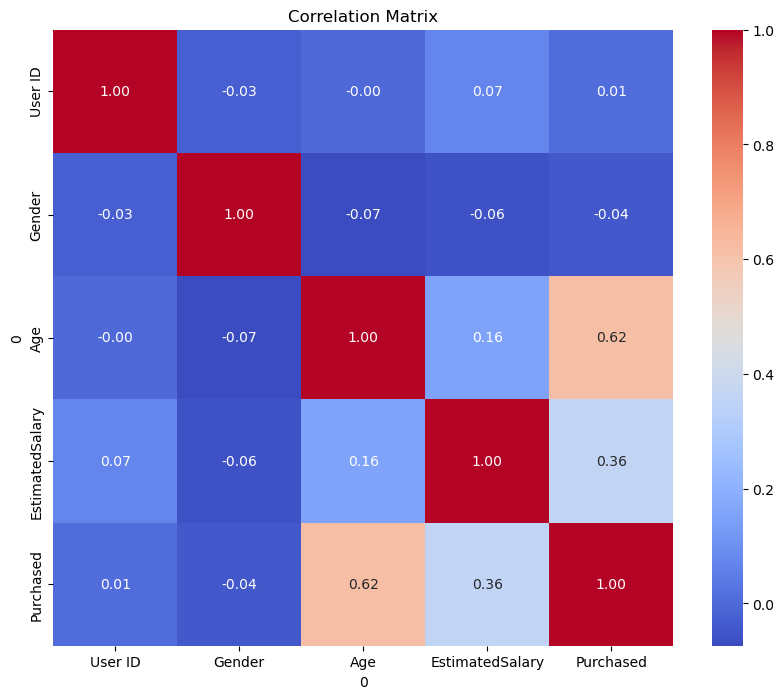

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
correlation_matrix = df.corr()  

# Rest of the code remains the same
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### closer look on features 

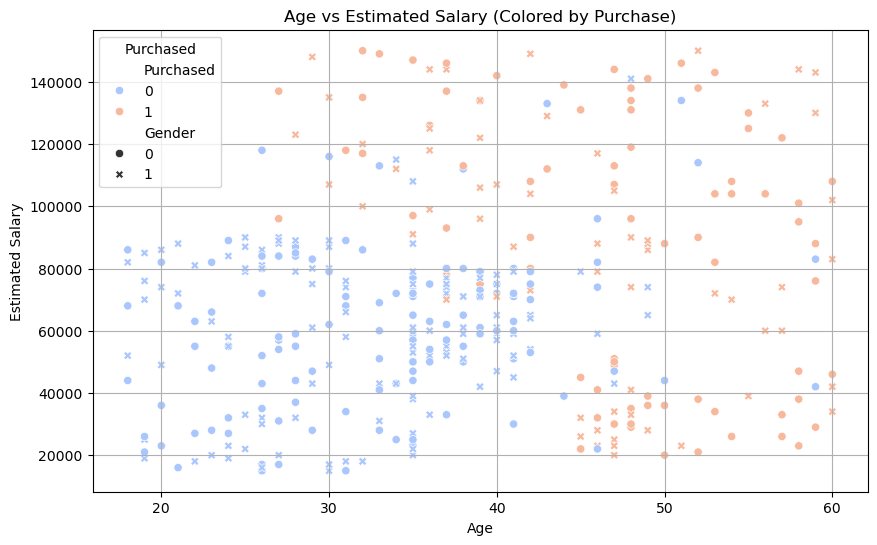

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='EstimatedSalary', hue='Purchased', style='Gender', palette='coolwarm')
plt.title('Age vs Estimated Salary (Colored by Purchase)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.grid(True)
plt.legend(title='Purchased')
plt.show()

C:\Users\Maram allah\AppData\Local\Temp\ipykernel_22976\2634996104.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Purchased', y='EstimatedSalary', data=df, palette='Set2')


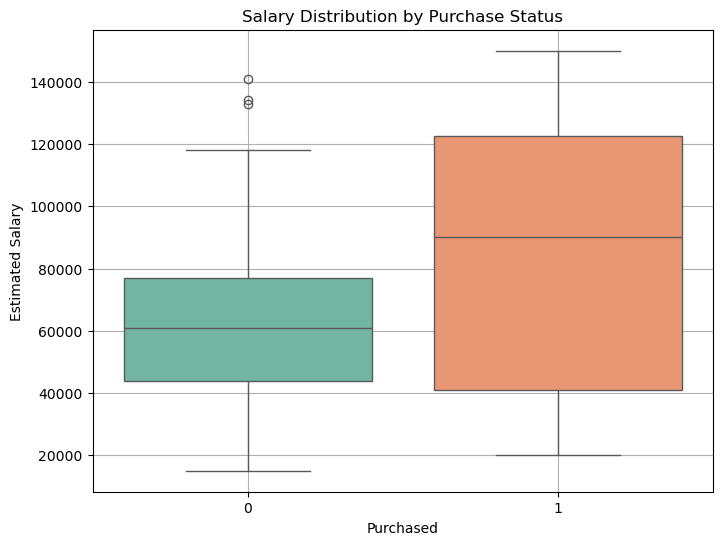

In [45]:
#salary distribution by Purchase
plt.figure(figsize=(8, 6))
sns.boxplot(x='Purchased', y='EstimatedSalary', data=df, palette='Set2')
plt.title('Salary Distribution by Purchase Status')
plt.xlabel('Purchased')
plt.ylabel('Estimated Salary')
plt.grid(True)
plt.show()

## getting our features and target

In [46]:
X_wg= df[['Age','EstimatedSalary','Gender']]
Y=df[['Purchased']]

## splitting data to train and test and validation 60/20/20

In [47]:
from sklearn.model_selection import train_test_split
X_Train, X_hold, Y_Train, Y_hold = train_test_split(X_wg, Y, test_size = 0.4, random_state = 0)
X_Test, X_Val, Y_Test, Y_Val = train_test_split(X_hold, Y_hold, test_size = 0.5, random_state = 0)


## scaleing our features 

In [48]:
scaler = StandardScaler()
X_Train = scaler.fit_transform(X_Train)
X_Val=scaler.fit_transform(X_Val)
X_Test = scaler.fit_transform(X_Test)

print(X_Train.shape)
print(X_Val.shape)
print(X_Test.shape)


(240, 3)
(80, 3)
(80, 3)


## Applying gridsearch to find best parametars such as k for knn

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define the parameter grid (values for k)
param_grid = {
    'n_neighbors': list(range(2, 11)),  # trying k from 2 to 10
    'metric': ['minkowski'],
    'p': [2]  # Euclidean distance
}

# Set up the KNN model
knn = KNeighborsClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # use all processors
)

# Fit the model on the training set
grid_search.fit(X_Train, Y_Train)

# Show the best k and the best score
print(f"Best K: {grid_search.best_params_['n_neighbors']}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

# Evaluate on the validation set
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_Val)
val_accuracy = accuracy_score(Y_Val, y_pred)
print(f"Validation Set Accuracy with Best K: {val_accuracy:.2f}")


Best K: 5
Best Cross-Validation Accuracy: 0.91
Validation Set Accuracy with Best K: 0.91


d:\projects\anaconda3\envs\tf39\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define the parameter grid (values for k)
param_grid = {
    'n_neighbors': list(range(2, 11)),  # trying k from 2 to 10
    'metric': ['minkowski'],
    'p': [2]  # Euclidean distance
}

# Set up the KNN model
knn = KNeighborsClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,  # 10-fold cross-validation
    n_jobs=-1  # use all processors
)

# Fit the model on the training set
grid_search.fit(X_Train, Y_Train)

# Show the best k and the best score
print(f"Best K: {grid_search.best_params_['n_neighbors']}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

# Evaluate on the validation set
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_Val)
val_accuracy = accuracy_score(Y_Val, y_pred)
print(f"Validation Set Accuracy with Best K: {val_accuracy:.2f}")


Best K: 7
Best Cross-Validation Accuracy: 0.91
Validation Set Accuracy with Best K: 0.91


d:\projects\anaconda3\envs\tf39\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## KNN 
#### Lower k means faster prediction, especially important for large datasets

In [51]:
#final test with k = 5 and test set 
knn_classifier = KNeighborsClassifier(
    n_neighbors=5,         
    metric='minkowski',    # Euclidean distance (p=2)
    p=2                   
)

#train the model
knn_classifier.fit(X_Train, Y_Train)  

#make predictions on validation set
y_pred = knn_classifier.predict(X_Test)  

#evaluate performance
accuracy = accuracy_score(Y_Test, y_pred)
conf_matrix = confusion_matrix(Y_Test, y_pred)
class_report = classification_report(Y_Test, y_pred)

print(f"Accuracy (k=5): {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy (k=5): 0.90

Confusion Matrix:
[[44  5]
 [ 3 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        49
           1       0.85      0.90      0.88        31

    accuracy                           0.90        80
   macro avg       0.89      0.90      0.90        80
weighted avg       0.90      0.90      0.90        80



d:\projects\anaconda3\envs\tf39\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [52]:
Train_acc = knn_classifier.score(X_Train, Y_Train)
print(f"Train Accuracy: {Train_acc:.2f}")

Train Accuracy: 0.92


## doing cross validation 

In [53]:
#k-fold with 5 splits
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
cv_knn_5 = KNeighborsClassifier(n_neighbors=5)
cv_scores_5 = cross_val_score(cv_knn_5, X_Train, Y_Train, cv=kf5)
avg_acc_5 = np.mean(cv_scores_5)

print("KFold = 5 → Cross-Validation Scores:", cv_scores_5)
print("KFold = 5 → Average Accuracy:", avg_acc_5)

#k-fold with 10 splits
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_knn_10 = KNeighborsClassifier(n_neighbors=3)
cv_scores_10 = cross_val_score(cv_knn_10, X_Train, Y_Train, cv=kf10)
avg_acc_10 = np.mean(cv_scores_10)

print("KFold = 10 → Cross-Validation Scores:", cv_scores_10)
print("KFold = 10 → Average Accuracy:", avg_acc_10)

#comparison
print("\n Accuracy Comparison Between 5-Fold and 10-Fold Cross Validation:")
print(f"Average Accuracy (5-Fold): {avg_acc_5:.4f}")
print(f"Average Accuracy (10-Fold): {avg_acc_10:.4f}")

if avg_acc_10 > avg_acc_5:
    print("10-Fold gave slightly better generalization.")
elif avg_acc_10 < avg_acc_5:
    print("5-Fold gave slightly better results.")
else:
    print("Both give the same average accuracy.")


d:\projects\anaconda3\envs\tf39\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
d:\projects\anaconda3\envs\tf39\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
d:\projects\anaconda3\envs\tf39\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
d:\projects\anaconda3\envs\tf39\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

KFold = 5 → Cross-Validation Scores: [0.875      0.95833333 0.89583333 0.85416667 0.875     ]
KFold = 5 → Average Accuracy: 0.8916666666666668


d:\projects\anaconda3\envs\tf39\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KFold = 10 → Cross-Validation Scores: [0.83333333 0.875      0.95833333 0.91666667 1.         0.79166667
 0.83333333 0.83333333 0.875      0.875     ]
KFold = 10 → Average Accuracy: 0.8791666666666667

 Accuracy Comparison Between 5-Fold and 10-Fold Cross Validation:
Average Accuracy (5-Fold): 0.8917
Average Accuracy (10-Fold): 0.8792
5-Fold gave slightly better results.


d:\projects\anaconda3\envs\tf39\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
d:\projects\anaconda3\envs\tf39\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
d:\projects\anaconda3\envs\tf39\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
d:\projects\anaconda3\envs\tf39\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

In [54]:
val_acc = knn_classifier.score(X_Val, Y_Val)
print(f"Validation Accuracy: {val_acc:.2f}")

Validation Accuracy: 0.91


In [55]:
y_test_pred=knn_classifier.predict(X_Test)


In [56]:
test_acc = knn_classifier.score(X_Test, Y_Test)
print(f"Test Accuracy: {test_acc:.2f}")

Test Accuracy: 0.90


In [57]:
# 9. Overfitting Discussion
# You can compare train, validation, test, and CV scores here
print("\n--- Overfitting Analysis ---")
print("Train Accuracy :", accuracy_score(Y_Train, knn_classifier.predict(X_Train)))
print("Validation Accuracy :", accuracy_score(Y_Val, knn_classifier.predict(X_Val)))
print("Test Accuracy:", accuracy_score(Y_Test,y_test_pred))
print("Cross-Validation Accuracy:", np.mean(cv_scores_5))


--- Overfitting Analysis ---
Train Accuracy : 0.9166666666666666
Validation Accuracy : 0.9125
Test Accuracy: 0.9
Cross-Validation Accuracy: 0.8916666666666668


In [58]:
# Making the Confusion Matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_Test, y_test_pred)
show = pd.DataFrame(cm,columns=["yes","no"],index=["yes","no"])
show.head()

,yes,no
yes,44,5
no,3,28


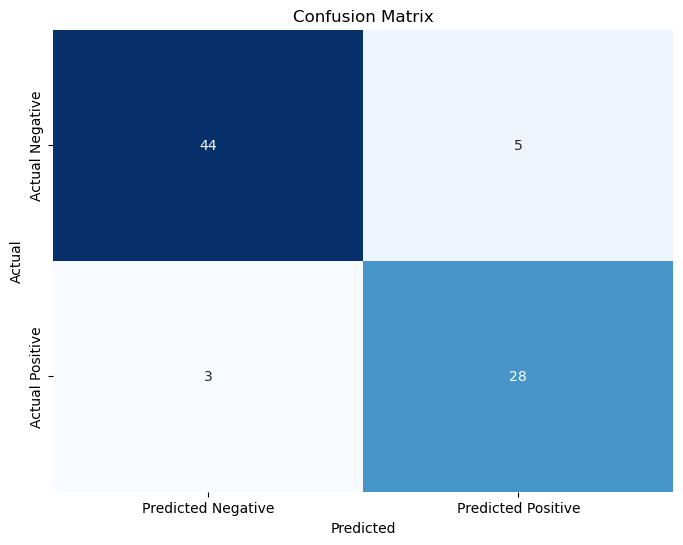

In [59]:
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

# Adding labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

Accuracy: Overall correctness.

Precision: Correctness of positive predictions.

Recall: Coverage of actual positives.

F1 Score: Balance between precision and recall.

In [60]:

y_pred_train = knn_classifier.predict(X_Train)

print("\n🔢 Training Metrics:")
print("Accuracy =", accuracy_score(Y_Train, y_pred_train))
print("Precision =", precision_score(Y_Train, y_pred_train))
print("Recall =", recall_score(Y_Train, y_pred_train))
print("F1 =", f1_score(Y_Train, y_pred_train))

print("\n🔢 Validation Metrics:")
print("Accuracy =", accuracy_score(Y_Val, knn_classifier.predict(X_Val)))
print("Precision =", precision_score(Y_Val, knn_classifier.predict(X_Val)))
print("Recall =", recall_score(Y_Val, knn_classifier.predict(X_Val)))
print("F1 =", f1_score(Y_Val, knn_classifier.predict(X_Val)))




print("\n🔢 Testing Metrics:")
print("Accuracy =", accuracy_score(Y_Test, y_test_pred))
print("Precision =", precision_score(Y_Test, y_test_pred))
print("Recall =", recall_score(Y_Test, y_test_pred))

print("F1 =", f1_score(Y_Test, y_test_pred))



🔢 Training Metrics:
Accuracy = 0.9166666666666666
Precision = 0.8636363636363636
Recall = 0.9047619047619048
F1 = 0.8837209302325582

🔢 Validation Metrics:
Accuracy = 0.9125
Precision = 0.8888888888888888
Recall = 0.8571428571428571
F1 = 0.8727272727272727

🔢 Testing Metrics:
Accuracy = 0.9
Precision = 0.8484848484848485
Recall = 0.9032258064516129
F1 = 0.875


## Learning curve

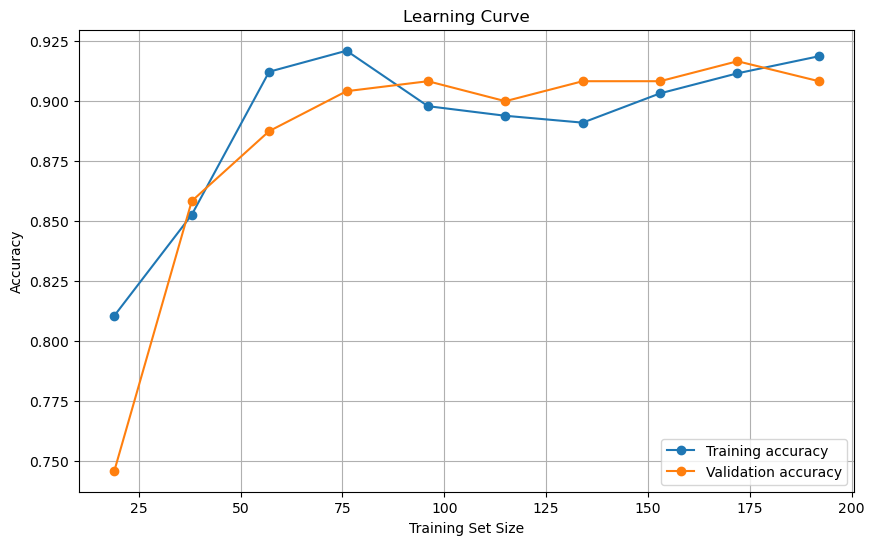

In [61]:
#Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    knn_classifier, X_Train, Y_Train.values.ravel(),
    cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation accuracy')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()